# Training

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from PIL import Image

In [2]:
train_path = "../data/train/"

In [3]:
DATA_PATH = "../data/lung_colon_image_set/lung_image_sets/"

### Benign lung tissues

In [4]:
img_path = DATA_PATH+'lung_n/'
no_cancer = os.listdir(img_path)

In [5]:
train_data = pd.DataFrame(no_cancer, columns=['id'])
train_data['label'] = 0
train_data['img_path'] = img_path
train_data.shape

(5000, 3)

In [6]:
train_data.to_csv('train_lung_binary_classification.csv', index=False)

### Lung squamous cell carcinomas

In [7]:
img_path = DATA_PATH+'lung_scc/'
cancer = os.listdir(img_path)

In [8]:
train_data = pd.DataFrame(cancer, columns=['id'])
train_data['label'] = 1
train_data['img_path'] = img_path
train_data.shape

(5000, 3)

In [9]:
train_data.to_csv('train_lung_binary_classification.csv', 
                  index=False, header=False, mode='a')

### Tansformation

In [10]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Load Data

In [11]:
train_labels = pd.read_csv("train_lung_binary_classification.csv")

In [12]:
train_labels['img_path'] = train_labels['img_path']  + train_labels['id']

In [13]:
train_labels.head()

,id,label,img_path
0,lungn129.jpeg,0,../data/lung_colon_image_set/lung_image_sets/l...
1,lungn1187.jpeg,0,../data/lung_colon_image_set/lung_image_sets/l...
2,lungn4646.jpeg,0,../data/lung_colon_image_set/lung_image_sets/l...
3,lungn3777.jpeg,0,../data/lung_colon_image_set/lung_image_sets/l...
4,lungn2772.jpeg,0,../data/lung_colon_image_set/lung_image_sets/l...


In [14]:
train_labels['label'].unique()

array([0, 1])

In [15]:
total_images = train_labels.shape[0]

#### Train and Validation Data

In [16]:
train, test_index = train_test_split(train_labels.index, test_size=0.20)

In [17]:
train_index, validation_index = train_test_split(train_labels.index, test_size=0.05)

In [18]:
print(train_index.shape)
print(validation_index.shape)

(9500,)
(500,)


### Pytorch Data Generator

In [19]:
class DataGenerator(data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, index):
        label = self.dataset['label'][index]
        
        image = Image.open(self.dataset['img_path'][index])
        img_raw = np.array(image)
        img = self.transform(img_raw)
        
        return img, int(label)

In [20]:
class DataGenerator_test(data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, index):
        label = self.dataset['label'][index]
        
        image = Image.open(self.dataset['img_path'][index])
        img_raw = np.array(image)
        img = self.transform(img_raw)       
        img_id = self.dataset['id'][index]
        
        return img, label, img_id

## Model

In [21]:
model = torchvision.models.resnet34(pretrained=False)

## Custom Fully connected Layer

In [22]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=1),
    torch.nn.Sigmoid()
)

In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Hyperparameters

In [24]:
epochs = 1
batch_size = 64

## Data Loaders

In [25]:
train_data = DataGenerator(train_labels, transform=transform)

In [26]:
train_index.shape

(9500,)

In [27]:
train_loader = data.DataLoader(train_data, batch_size=batch_size,
                              sampler= data.SubsetRandomSampler(train_index))

In [28]:
print(len(train_loader))

149


In [29]:
valid_loader = data.DataLoader(train_data, batch_size=batch_size,
                              sampler= data.SubsetRandomSampler(validation_index))

In [30]:
print(len(valid_loader))

8


### Train Model

In [31]:
## USE GPU ##
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

print_every = 50

loss_sum = 0
correct_sum = 0
samples = 0
sum_precision = 0
sum_recall = 0
valid_count = 0
total_train_batch = 0



train_metrics = []
valid_metrics = []

for epoch in range(epochs):
    ## Training
    batch = 1
    model.train()
    for x, y in train_loader:
        
        total_train_batch += 1
        x = x.cuda()
        y = y.cuda()
        y = y.view(-1, 1).float()
        
        optimizer.zero_grad()
        output = model(x)

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        samples += x.shape[0]
        loss_sum += loss.item() * x.shape[0] 
        y_pred = (output >= 0.5).float()
        num_corrects = torch.sum(y_pred == y)
        correct_sum += num_corrects
  
        precision = precision_score(y.to('cpu'), y_pred.to('cpu'))
        recall = recall_score(y.to('cpu'), y_pred.to('cpu'))
        sum_precision += precision
        sum_recall += recall
        
        if batch % 500 == 0:
            torch.save(model.state_dict(), 'checkpoint_{0}.pth'.format(batch))
            
        if (batch % print_every == 0) or (batch == 1):
            train_loss = float(loss_sum)/float(samples)
            train_acc = float(correct_sum)/float(samples)
            train_prec = float(sum_precision)/float(total_train_batch)
            train_rec = float(sum_recall)/float(total_train_batch)
            train_metrics.append([epoch+1, total_train_batch, train_loss, train_acc, train_prec, train_rec])
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Batch {batch}.. "
                  f"Train loss: {train_loss:.3f}.. "
                  f"Train acc: {train_acc:.3f}.. "
                  f"Train avg precision: {train_prec:.3f}.. "
                  f"Train avg recall: {train_rec:.3f}.. ")
            
            model.eval()
            with torch.no_grad():
                val_loss_sum = 0
                val_precision_sum = 0
                val_recall_sum = 0
                val_samples = 0
                val_batch = 1
                
                for x_val, y_val in valid_loader:
                    x_val = x_val.cuda()
                    y_val = y_val.cuda()
                    y_val = y_val.view(-1, 1).float()

                    output_val = model(x_val)
                    loss_val = criterion(output_val, y_val)
                    y_val_pred = (output_val >= 0.5).float()

                    val_samples += x_val.shape[0]
                    val_loss_sum += loss_val.item() * x_val.shape[0]

                    val_precision = precision_score(y_val.to('cpu'), y_val_pred.to('cpu'))
                    val_recall = recall_score(y_val.to('cpu'), y_val_pred.to('cpu'))
                    val_precision_sum += val_precision
                    val_recall_sum += val_recall
                    val_batch+=1


                val = float(val_loss_sum)/float(val_samples)
                prec = float(val_precision_sum)/float(val_batch)
                rec = float(val_recall_sum)/float(val_batch)

                valid_metrics.append([epoch+1, val, prec, rec])
                        
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Valid loss: {val:.3f}.. "
                      f"Valid avg presision: {prec:.3f}.. "
                      f"Valid avg recall: {rec:.3f}.. ")
            model.train()
                
            
        batch +=1


/home/erick/anaconda3/envs/cancer/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/1.. Batch 1.. Train loss: 0.714.. Train acc: 0.484.. Train avg precision: 0.000.. Train avg recall: 0.000.. 


/home/erick/anaconda3/envs/cancer/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erick/anaconda3/envs/cancer/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erick/anaconda3/envs/cancer/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erick/anaconda3/envs/cancer/lib/python3.9/site-packages

Epoch 1/1.. Valid loss: 49.000.. Valid avg presision: 0.000.. Valid avg recall: 0.000.. 
Epoch 1/1.. Batch 50.. Train loss: 0.109.. Train acc: 0.971.. Train avg precision: 0.961.. Train avg recall: 0.965.. 
Epoch 1/1.. Valid loss: 0.148.. Valid avg presision: 0.889.. Valid avg recall: 0.830.. 
Epoch 1/1.. Batch 100.. Train loss: 0.066.. Train acc: 0.982.. Train avg precision: 0.977.. Train avg recall: 0.980.. 
Epoch 1/1.. Valid loss: 0.002.. Valid avg presision: 0.889.. Valid avg recall: 0.889.. 


In [32]:
torch.save(model.state_dict(), 'checkpoint_final_20210315_lung.pth')

In [33]:
np.save("train_metrics", train_metrics)
np.save("valid_metrics", valid_metrics)

In [34]:
np.save("train_index", train_index)
np.save("validation_index", validation_index)
np.save("test_index", test_index)

## Model Evaluation

In [35]:
train_metrics = np.array(train_metrics)

In [36]:
valid_metrics = np.array(valid_metrics)

In [37]:
metrics = pd.DataFrame(train_metrics, 
                       columns=["epoch", "batch", "loss", "accuracy",
                                "Avg. Precision", "Avg. Recall"])

In [38]:
metrics["valid_loss"] = valid_metrics[:,1]
metrics["Avg. Valid. Precision"] = valid_metrics[:,2]
metrics["Avg. Valid. Recall"] = valid_metrics[:,3]

In [39]:
metrics.head()

,epoch,batch,loss,accuracy,Avg. Precision,Avg. Recall,valid_loss,Avg. Valid. Precision,Avg. Valid. Recall
0,1.0,1.0,0.713942,0.484375,0.000000,0.000000,49.000000,0.000000,0.000000
1,1.0,50.0,0.109200,0.970938,0.961189,0.964595,0.147633,0.888889,0.829501
2,1.0,100.0,0.065714,0.981875,0.976630,0.979663,0.001699,0.888889,0.888889


### Training Metrics

<AxesSubplot:xlabel='batch', ylabel='loss'>

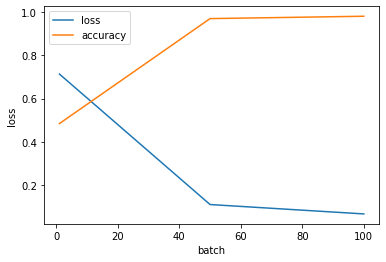

In [40]:
sns.lineplot(y="loss", x="batch", label='loss', data=metrics)
sns.lineplot(y="accuracy", x="batch", label='accuracy', data=metrics)

<AxesSubplot:xlabel='batch', ylabel='Avg. Precision'>

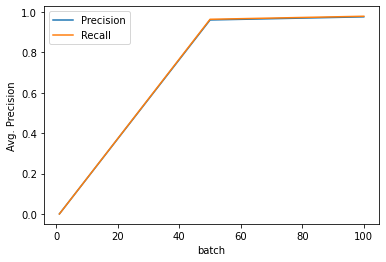

In [41]:
sns.lineplot(y="Avg. Precision", x="batch", label='Precision', data=metrics)
sns.lineplot(y="Avg. Recall", x="batch", label='Recall', data=metrics)

### Validation Metrics

<AxesSubplot:xlabel='batch', ylabel='valid_loss'>

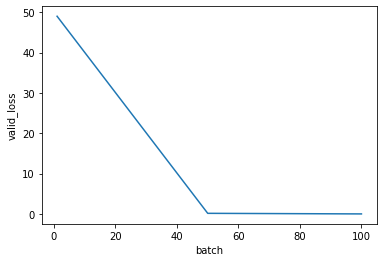

In [42]:
sns.lineplot(y="valid_loss", x="batch", data=metrics)

<AxesSubplot:xlabel='batch', ylabel='Avg. Valid. Precision'>

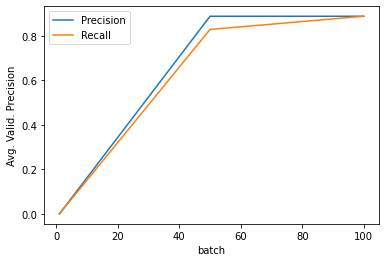

In [43]:
sns.lineplot(y="Avg. Valid. Precision", x="batch", label='Precision', data=metrics)
sns.lineplot(y="Avg. Valid. Recall", x="batch", label='Recall', data=metrics)

# TEST MODEL PREDICTIONS

In [44]:
model_test = torchvision.models.resnet34(pretrained=False)

In [45]:
model_test.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=1),
    torch.nn.Sigmoid()
)

In [46]:
model_test.load_state_dict(torch.load("checkpoint_final_20210314_lung.pth"))

<All keys matched successfully>

### Test dataloader

In [47]:
test_labels = train_labels[train_labels.index.isin(test_index)]

In [48]:
test_data = DataGenerator_test(test_labels, transform=transform)
test_loader = data.DataLoader(test_data, batch_size=batch_size, 
                              sampler=data.SubsetRandomSampler(test_index))

In [49]:
len(test_loader)

32

In [50]:
## USE GPU
model_test = model_test.cuda()

predictions = []
predictions_raw = []
model_test.eval()
total_test_batches = len(test_loader)
img_ids = []
for x,y, ids in tqdm(test_loader, total = total_test_batches):
    x = x.cuda()
    y = y.cuda()
    y = y.view(-1, 1).float()
    img_ids.append(ids)
    
    with torch.no_grad():
        out = model_test(x)
        predictions_raw.append(out.float().cpu().numpy())
        predictions.append((out >= 0.5).float().cpu().numpy())

100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


In [51]:
y_hat = []
for i in range(len(predictions)):
    for val in predictions[i]:
        y_hat.append(int(val[0]))
        
img_pred_id = []
for i in range(len(img_ids)):
    for val in img_ids[i]:
        img_pred_id.append(val)

In [52]:
y_test = []

for img_id in img_pred_id:
    y_test.append(int(test_labels[test_labels.id == img_id]['label']))

#### Confusion Matrix

In [53]:
confusion_matrix = confusion_matrix(y_test, y_hat)

<AxesSubplot:>

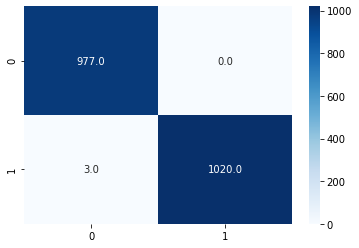

In [54]:
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, fmt=".1f")

#### ROC Curve

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat)

In [56]:
roc_auc_score = roc_auc_score(y_test, y_hat)

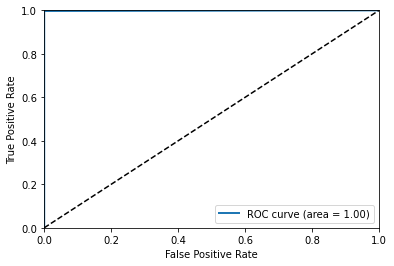

In [57]:
plt.plot(fpr, tpr, linewidth=2, label='ROC curve (area = %0.2f)' % roc_auc_score)
plt.plot([0,1], [0,1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Predictions

In [ ]:
def read_tif_image(path):
    raw_image = cv2.imread(path)
    b,g,r = cv2.split(raw_image)
    return cv2.merge([r,g,b])

In [ ]:
positive_examples_ids = np.where(np.array(y_hat) == 1)
negative_examples_ids = np.where(np.array(y_hat) == 0)

In [ ]:
str(test_labels[test_labels.id == img_id]['img_path'])

In [ ]:
test_labels[test_labels.id == "de988a3eb301213d63a75c8f0dd3a60228020ae3"]

In [ ]:
fix, ax = plt.subplots(2,5, figsize=(15,8))

ax[0,0].set_ylabel('Positive samples', size='large')
ax[1,0].set_ylabel('Negative samples', size='large')
# Positive
for i,idx in enumerate(positive_examples_ids[0][:5]):
    image_id = img_pred_id[idx]

    image_path = train_path + image_id + ".tif"
    print(image_path)
    ax[0,i].imshow(read_tif_image(image_path))
    
#Negative   
print("---")
for i,idx in enumerate(negative_examples_ids[0][:5]):
    image_id = img_pred_id[idx]

    image_path = train_path + image_id + ".tif"
    print(image_path)
    ax[1,i].imshow(read_tif_image(image_path))